# WVA Model-Based Mode Analysis

This notebook analyzes WVA (Workload Variant Autoscaler) experiments running in **MODEL-ONLY mode**.

## Key Metrics

### Prediction vs Reality
- **Predicted ITL/TTFT** - From optimizer at reconciliation N (what WVA predicts)
- **Observed ITL/TTFT** - From Prometheus at reconciliation N+1 (what actually happened)
- **Prediction Error** - Difference between predicted and observed

### Scaling Behavior
- **Target Replicas** - What optimizer decided
- **Current Replicas** - Actual running replicas
- **Scaling Actions** - Scale-up, scale-down, no-change

### SLO Compliance
- **SLO ITL** - Target inter-token latency (typically 10ms)
- **SLO TTFT** - Target time-to-first-token (typically 1000ms)
- **SLO Violations** - When observed metrics exceed SLOs

## Workflow

1. Load experiment data from timestamped directory
2. Parse WVA controller logs
3. Align predictions (reconciliation N) with observations (reconciliation N+1)
4. Visualize scaling behavior and performance
5. Analyze prediction accuracy and SLO compliance

## 1. Setup and Configuration

In [1]:
import json
import sys
import re
from pathlib import Path
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import numpy as np

# Plotting style - match wva_analysis.ipynb
plt.style.use('seaborn-v0_8')
%matplotlib inline

# # Configuration
# EXP_NAME = "model-based-moderate-parallel-20251128-182839"
# EXPERIMENT_DIR = Path(f"experiment-data/{EXP_NAME}")
# LOG_FILE = EXPERIMENT_DIR / "wva-controller-logs.jsonl"

# print(f"✅ Configuration loaded")
# print(f"   Experiment: {EXP_NAME}")
# print(f"   Log file: {LOG_FILE}")

KV_CACHE_THRESHOLD = 0.5  # Latency threshold in milliseconds to consider KV cache hit
QUEUE_LENGTH_THRESHOLD = 5  # Queue length threshold to consider queuing delay significant
SHOW_DESIRED_REPLICAS = True  # Whether to show desired replicas in the plot

## 2. Select Experiment Directory

In [2]:
# Auto-detect latest model-based experiment
# Handle broken working directory in kernel
try:
    from pathlib import Path as _Path
    notebook_dir = _Path.cwd()
except:
    from pathlib import Path as _Path
    notebook_dir = _Path('/Users/tom/Desktop/llm-d-communitydev/tom_wva/config/samples/wva-experiments')

data_dir = notebook_dir / 'experiment-data'
if data_dir.exists():
    experiments = sorted(data_dir.glob('model-based-*'), reverse=True)
    if experiments:
        EXPERIMENT_DIR = str(experiments[0])
        print(f"✓ Auto-detected latest experiment: {experiments[0].name}")
    else:
        EXPERIMENT_DIR = str(notebook_dir / 'experiment-data/model-based-moderate-load-20251126-120000')
        print(f"⚠ No model-based experiments found, using example path")
else:
    EXPERIMENT_DIR = str(notebook_dir / 'experiment-data/model-based-moderate-load-20251126-120000')
    print(f"⚠ Data directory not found, using example path")

EXPERIMENT_DIR = Path(EXPERIMENT_DIR)
LOG_FILE = EXPERIMENT_DIR / 'wva-controller-logs.jsonl'
METRICS_CSV = EXPERIMENT_DIR / 'metrics.csv'

print(f"Experiment directory: {EXPERIMENT_DIR}")
print(f"Log file: {LOG_FILE}")
print(f"Metrics CSV: {METRICS_CSV}")

# Verify files exist
if not EXPERIMENT_DIR.exists():
    print(f"❌ Experiment directory not found: {EXPERIMENT_DIR}")
    print(f"Please run an experiment first with: bash run-experiment.sh model-based-moderate-parallel.yaml")
elif not LOG_FILE.exists():
    print(f"❌ Log file not found: {LOG_FILE}")
else:
    print(f"✓ Files found")

✓ Auto-detected latest experiment: model-based-moderate-parallel-20251203-144456
Experiment directory: /Users/tom/Desktop/llm-d-communitydev/tom_wva/config/samples/wva-experiments/experiment-data/model-based-moderate-parallel-20251203-144456
Log file: /Users/tom/Desktop/llm-d-communitydev/tom_wva/config/samples/wva-experiments/experiment-data/model-based-moderate-parallel-20251203-144456/wva-controller-logs.jsonl
Metrics CSV: /Users/tom/Desktop/llm-d-communitydev/tom_wva/config/samples/wva-experiments/experiment-data/model-based-moderate-parallel-20251203-144456/metrics.csv
✓ Files found


## 3. Parse WVA Logs

Extract key events from WVA controller logs:
- **Predictions** - From optimizer solution (reconciliation N)
- **Observations** - From Prometheus metrics (reconciliation N+1)
- **Scaling Decisions** - Target replica changes
- **SLO Values** - ITL and TTFT thresholds

In [3]:
def parse_optimization_solution(solution_str):
    """Extract predicted ITL and TTFT from optimization solution."""
    itl_match = re.search(r'itl=([0-9.]+)', solution_str)
    ttft_match = re.search(r'ttft=([0-9.]+)', solution_str)
    replicas_match = re.search(r'numRep=([0-9]+)', solution_str)
    maxbatch_match = re.search(r'maxBatch=([0-9]+)', solution_str)
    cost_match = re.search(r'cost=([0-9.]+)', solution_str)
    
    return {
        'predicted_itl': float(itl_match.group(1)) if itl_match else None,
        'predicted_ttft': float(ttft_match.group(1)) if ttft_match else None,
        'predicted_replicas': int(replicas_match.group(1)) if replicas_match else None,
        'max_batch': int(maxbatch_match.group(1)) if maxbatch_match else None,
        'cost': float(cost_match.group(1)) if cost_match else None
    }

# Parse logs
predictions = []
observations = []
scaling_decisions = []
slo_values = []
kv_cache_metrics = []
queue_metrics = []

# Debug counters
observation_msg_count = 0
observation_parse_errors = 0

print("Parsing WVA controller logs...")
print(f"Log file: {LOG_FILE}")
print(f"Starting with empty lists:")
print(f"  predictions: {len(predictions)}, observations: {len(observations)}")

with open(LOG_FILE, 'r') as f:
    for line_num, line in enumerate(f, 1):
        try:
            log = json.loads(line.strip())
            ts = log.get('ts', '')
            msg = log.get('msg', '')
            level = log.get('level', '')
            
            # Convert timestamp to datetime
            try:
                dt = datetime.fromisoformat(ts.replace('Z', '+00:00'))
            except:
                continue
            
            # Extract predictions from optimizer
            if 'Optimization solution' in msg:
                prediction = parse_optimization_solution(msg)
                predictions.append({
                    'timestamp': dt,
                    **prediction
                })
            
            # Extract scaling decisions
            elif 'Processing decision' in msg:
                current_match = re.search(r'current=([0-9]+)', msg)
                target_match = re.search(r'target=([0-9]+)', msg)
                action_match = re.search(r'action=([a-z-]+)', msg)
                
                scaling_decisions.append({
                    'timestamp': dt,
                    'current_replicas': int(current_match.group(1)) if current_match else None,
                    'target_replicas': int(target_match.group(1)) if target_match else None,
                    'action': action_match.group(1) if action_match else None
                })
            
            # Extract SLO values
            elif 'Found SLO for model' in msg:
                slo_itl_match = re.search(r'slo-tpot=([0-9]+)', msg)
                slo_ttft_match = re.search(r'slo-ttft=([0-9]+)', msg)
                
                slo_values.append({
                    'timestamp': dt,
                    'slo_itl': int(slo_itl_match.group(1)) if slo_itl_match else None,
                    'slo_ttft': int(slo_ttft_match.group(1)) if slo_ttft_match else None
                })
            
            # Extract KV cache metrics (per-pod only, not aggregate summary)
            elif 'KV cache metric:' in msg and 'pod=' in msg:
                pod_match = re.search(r'pod=([a-zA-Z0-9-]+)', msg)
                usage_match = re.search(r'usage=([0-9.]+)', msg)
                pct_match = re.search(r'\(([0-9.]+)%\)', msg)
                
                if pod_match:  # Only append if we successfully extracted pod name
                    kv_cache_metrics.append({
                        'timestamp': dt,
                        'pod': pod_match.group(1),
                        'kv_cache_usage': float(usage_match.group(1)) if usage_match else None,
                        'kv_cache_pct': float(pct_match.group(1)) if pct_match else None
                    })
            
            # Extract queue metrics
            elif 'Queue metric' in msg:
                pod_match = re.search(r'pod=([a-zA-Z0-9-]+)', msg)
                queue_match = re.search(r'queueLength=([0-9]+)', msg)
                
                if pod_match:
                    queue_metrics.append({
                        'timestamp': dt,
                        'pod': pod_match.group(1),
                        'queue_length': int(queue_match.group(1)) if queue_match else None
                    })
            
            # Extract observed metrics (from Prometheus)
            # Note: These come from the prepareVariantAutoscalings function
            # Match both old format "✓ Metrics collected for VA" and new format "Metrics collected for VA"
            elif 'Metrics collected for VA' in msg:
                observation_msg_count += 1
                replicas_match = re.search(r'replicas=([0-9]+)', msg)
                ttft_match = re.search(r'ttft=([0-9.]+)ms', msg)
                itl_match = re.search(r'itl=([0-9.]+)ms', msg)
                
                if not replicas_match or not ttft_match or not itl_match:
                    observation_parse_errors += 1
                    if observation_parse_errors <= 3:  # Only show first 3 errors
                        print(f"  ⚠️ Line {line_num}: Failed to parse observation")
                        print(f"     replicas: {'✓' if replicas_match else '✗'}, ttft: {'✓' if ttft_match else '✗'}, itl: {'✓' if itl_match else '✗'}")
                        print(f"     msg: {msg[:150]}...")
                else:
                    observations.append({
                        'timestamp': dt,
                        'observed_replicas': int(replicas_match.group(1)),
                        'observed_ttft': float(ttft_match.group(1)),
                        'observed_itl': float(itl_match.group(1))
                    })
                    if len(observations) <= 3:  # Debug: show first 3 successful parses
                        print(f"  ✓ Line {line_num}: Parsed observation #{len(observations)}: replicas={replicas_match.group(1)}, ttft={ttft_match.group(1)}ms, itl={itl_match.group(1)}ms")
                    
        except json.JSONDecodeError:
            continue
        except Exception as e:
            print(f"Error parsing line {line_num}: {e}")
            continue

# Convert to DataFrames
df_predictions = pd.DataFrame(predictions)
df_observations = pd.DataFrame(observations)
df_scaling = pd.DataFrame(scaling_decisions)
df_slo = pd.DataFrame(slo_values)
df_kv_cache = pd.DataFrame(kv_cache_metrics)
df_queue = pd.DataFrame(queue_metrics)

# Debug: Check list sizes before DataFrame conversion
print(f"\nDEBUG: Raw list sizes:")
print(f"  predictions list: {len(predictions)}")
print(f"  observations list: {len(observations)}")
print(f"  scaling_decisions list: {len(scaling_decisions)}")
print(f"  slo_values list: {len(slo_values)}")

print(f"\n✓ Parsed {len(df_predictions)} predictions")
print(f"✓ Parsed {len(df_observations)} observations")
if observation_msg_count > 0:
    print(f"  Found {observation_msg_count} observation messages, {observation_parse_errors} parse errors")
    if len(observations) > 0:
        print(f"  ✓ Successfully parsed {len(observations)} observations into list")
    else:
        print(f"  ✗ WARNING: observations list is empty despite finding {observation_msg_count} messages!")
print(f"✓ Parsed {len(df_scaling)} scaling decisions")
print(f"✓ Parsed {len(df_slo)} SLO entries")
print(f"✓ Parsed {len(df_kv_cache)} KV cache measurements")
print(f"✓ Parsed {len(df_queue)} queue measurements")

# Show samples
if len(df_predictions) > 0:
    print("\nSample prediction:")
    print(df_predictions.head(1).to_string())

if len(df_observations) > 0:
    print("\nSample observation:")
    print(df_observations.head(1).to_string())

if len(df_kv_cache) > 0:
    print("\nSample KV cache metric:")
    print(df_kv_cache.head(1).to_string())

Parsing WVA controller logs...
Log file: /Users/tom/Desktop/llm-d-communitydev/tom_wva/config/samples/wva-experiments/experiment-data/model-based-moderate-parallel-20251203-144456/wva-controller-logs.jsonl
Starting with empty lists:
  predictions: 0, observations: 0
  ✓ Line 12: Parsed observation #1: replicas=1, ttft=0.00ms, itl=0.00ms
  ✓ Line 42: Parsed observation #2: replicas=1, ttft=0.00ms, itl=0.00ms
  ✓ Line 72: Parsed observation #3: replicas=1, ttft=0.00ms, itl=0.00ms

DEBUG: Raw list sizes:
  predictions list: 17
  observations list: 17
  scaling_decisions list: 17
  slo_values list: 17

✓ Parsed 17 predictions
✓ Parsed 17 observations
  Found 17 observation messages, 0 parse errors
  ✓ Successfully parsed 17 observations into list
✓ Parsed 17 scaling decisions
✓ Parsed 17 SLO entries
✓ Parsed 34 KV cache measurements
✓ Parsed 34 queue measurements

Sample prediction:
                         timestamp  predicted_itl  predicted_ttft  predicted_replicas  max_batch   cost
0 20

## 4. Align Predictions with Observations

**Key Concept**: Prediction at reconciliation N applies to reconciliation N+1.

- Optimizer runs at time T → predicts ITL/TTFT
- Those predictions are for the NEXT reconciliation
- Observed metrics at time T+interval reflect what the previous prediction estimated

We align predictions with the NEXT observation to measure accuracy.

In [4]:
# Sort by timestamp (only if DataFrames are not empty)
if len(df_predictions) > 0 and 'timestamp' in df_predictions.columns:
    df_predictions = df_predictions.sort_values('timestamp').reset_index(drop=True)
if len(df_observations) > 0 and 'timestamp' in df_observations.columns:
    df_observations = df_observations.sort_values('timestamp').reset_index(drop=True)
if len(df_scaling) > 0 and 'timestamp' in df_scaling.columns:
    df_scaling = df_scaling.sort_values('timestamp').reset_index(drop=True)

# Check if we have the necessary data
if len(df_predictions) == 0:
    print("⚠️ No predictions found in logs")
if len(df_observations) == 0:
    print("⚠️ No observations found in logs")
    print("   Make sure the log file contains '✓ Metrics collected for VA' messages")

# Align predictions with next observation
aligned_data = []

# Only proceed if we have both predictions and observations
if len(df_predictions) > 0 and len(df_observations) > 0:
    for i in range(len(df_predictions)):
        pred_row = df_predictions.iloc[i]
        pred_time = pred_row['timestamp']
        
        # Find the next observation after this prediction
        future_obs = df_observations[df_observations['timestamp'] > pred_time]
        
        if len(future_obs) > 0:
            obs_row = future_obs.iloc[0]
            
            # Compute prediction error
            pred_error_itl = None
            pred_error_ttft = None
            
            if pred_row['predicted_itl'] is not None and obs_row['observed_itl'] is not None:
                pred_error_itl = obs_row['observed_itl'] - pred_row['predicted_itl']
            
            if pred_row['predicted_ttft'] is not None and obs_row['observed_ttft'] is not None:
                pred_error_ttft = obs_row['observed_ttft'] - pred_row['predicted_ttft']
            
            aligned_data.append({
                'prediction_time': pred_time,
                'observation_time': obs_row['timestamp'],
                'time_delta_seconds': (obs_row['timestamp'] - pred_time).total_seconds(),
                'predicted_itl': pred_row['predicted_itl'],
                'observed_itl': obs_row['observed_itl'],
                'pred_error_itl': pred_error_itl,
                'predicted_ttft': pred_row['predicted_ttft'],
                'observed_ttft': obs_row['observed_ttft'],
                'pred_error_ttft': pred_error_ttft,
                'predicted_replicas': pred_row['predicted_replicas'],
                'observed_replicas': obs_row['observed_replicas'],
            })

df_aligned = pd.DataFrame(aligned_data)

# Add time_minutes column for plotting
if len(df_aligned) > 0:
    start_time = df_aligned['observation_time'].min()
    df_aligned['time_minutes'] = (df_aligned['observation_time'] - start_time).dt.total_seconds() / 60

print(f"✓ Created {len(df_aligned)} aligned prediction-observation pairs")
print(f"\nSample aligned data:")
if len(df_aligned) > 0:
    print(df_aligned.head(3).to_string())

✓ Created 16 aligned prediction-observation pairs

Sample aligned data:
                   prediction_time                 observation_time  time_delta_seconds  predicted_itl  observed_itl  pred_error_itl  predicted_ttft  observed_ttft  pred_error_ttft  predicted_replicas  observed_replicas  time_minutes
0 2025-12-03 19:40:13.529000+00:00 2025-12-03 19:41:13.561000+00:00              60.032          7.514           0.0          -7.514       15.415337            0.0       -15.415337                   1                  1      0.000000
1 2025-12-03 19:41:13.561000+00:00 2025-12-03 19:42:13.585000+00:00              60.024          7.514           0.0          -7.514       15.415337            0.0       -15.415337                   1                  1      1.000400
2 2025-12-03 19:42:13.585000+00:00 2025-12-03 19:43:13.613000+00:00              60.028          7.514           0.0          -7.514       15.415337            0.0       -15.415337                   1                  1      2

## 5. Add SLO Information

In [5]:
# Get SLO values (should be constant throughout experiment)
if len(df_slo) > 0:
    SLO_ITL = df_slo['slo_itl'].iloc[0]
    SLO_TTFT = df_slo['slo_ttft'].iloc[0]
else:
    # Default values
    SLO_ITL = 10
    SLO_TTFT = 1000

print(f"SLO ITL: {SLO_ITL} ms")
print(f"SLO TTFT: {SLO_TTFT} ms")

# Add SLO violation flags to aligned data
if len(df_aligned) > 0:
    df_aligned['slo_itl_violated'] = df_aligned['observed_itl'] > SLO_ITL
    df_aligned['slo_ttft_violated'] = df_aligned['observed_ttft'] > SLO_TTFT
    df_aligned['any_slo_violated'] = df_aligned['slo_itl_violated'] | df_aligned['slo_ttft_violated']
    
    violation_count = df_aligned['any_slo_violated'].sum()
    violation_pct = (violation_count / len(df_aligned)) * 100
    
    print(f"\nSLO Violations: {violation_count}/{len(df_aligned)} ({violation_pct:.1f}%)")

SLO ITL: 10 ms
SLO TTFT: 1000 ms

SLO Violations: 6/16 (37.5%)


## 6. Summary Statistics

In [6]:
if len(df_aligned) > 0:
    print("="*60)
    print("PREDICTION ACCURACY SUMMARY")
    print("="*60)
    
    print("\nITL (Inter-Token Latency) Predictions:")
    print(f"  Mean Error: {df_aligned['pred_error_itl'].mean():.2f} ms")
    print(f"  Abs Mean Error: {df_aligned['pred_error_itl'].abs().mean():.2f} ms")
    print(f"  Std Dev: {df_aligned['pred_error_itl'].std():.2f} ms")
    print(f"  Min Error: {df_aligned['pred_error_itl'].min():.2f} ms")
    print(f"  Max Error: {df_aligned['pred_error_itl'].max():.2f} ms")
    
    print("\nTTFT (Time to First Token) Predictions:")
    print(f"  Mean Error: {df_aligned['pred_error_ttft'].mean():.2f} ms")
    print(f"  Abs Mean Error: {df_aligned['pred_error_ttft'].abs().mean():.2f} ms")
    print(f"  Std Dev: {df_aligned['pred_error_ttft'].std():.2f} ms")
    print(f"  Min Error: {df_aligned['pred_error_ttft'].min():.2f} ms")
    print(f"  Max Error: {df_aligned['pred_error_ttft'].max():.2f} ms")
    
    print("\n" + "="*60)
    print("SCALING BEHAVIOR SUMMARY")
    print("="*60)
    
    if len(df_scaling) > 0:
        action_counts = df_scaling['action'].value_counts()
        print("\nScaling Actions:")
        for action, count in action_counts.items():
            pct = (count / len(df_scaling)) * 100
            print(f"  {action}: {count} ({pct:.1f}%)")
        
        print(f"\nReplica Range: {df_scaling['current_replicas'].min()} - {df_scaling['current_replicas'].max()}")
else:
    print("No aligned data available for statistics")

PREDICTION ACCURACY SUMMARY

ITL (Inter-Token Latency) Predictions:
  Mean Error: -0.28 ms
  Abs Mean Error: 5.83 ms
  Std Dev: 8.34 ms
  Min Error: -9.63 ms
  Max Error: 22.17 ms

TTFT (Time to First Token) Predictions:
  Mean Error: -0.64 ms
  Abs Mean Error: 11.13 ms
  Std Dev: 14.76 ms
  Min Error: -17.14 ms
  Max Error: 35.82 ms

SCALING BEHAVIOR SUMMARY

Scaling Actions:
  no-change: 9 (52.9%)
  scale-up: 4 (23.5%)
  scale-down: 4 (23.5%)

Replica Range: 1 - 7


## 7. Visualization: Prediction vs Observation

In [7]:
# Create plots directory if it doesn't exist
plots_dir = EXPERIMENT_DIR / 'plots'
plots_dir.mkdir(exist_ok=True)
print(f"✓ Plots directory ready: {plots_dir}")

✓ Plots directory ready: /Users/tom/Desktop/llm-d-communitydev/tom_wva/config/samples/wva-experiments/experiment-data/model-based-moderate-parallel-20251203-144456/plots


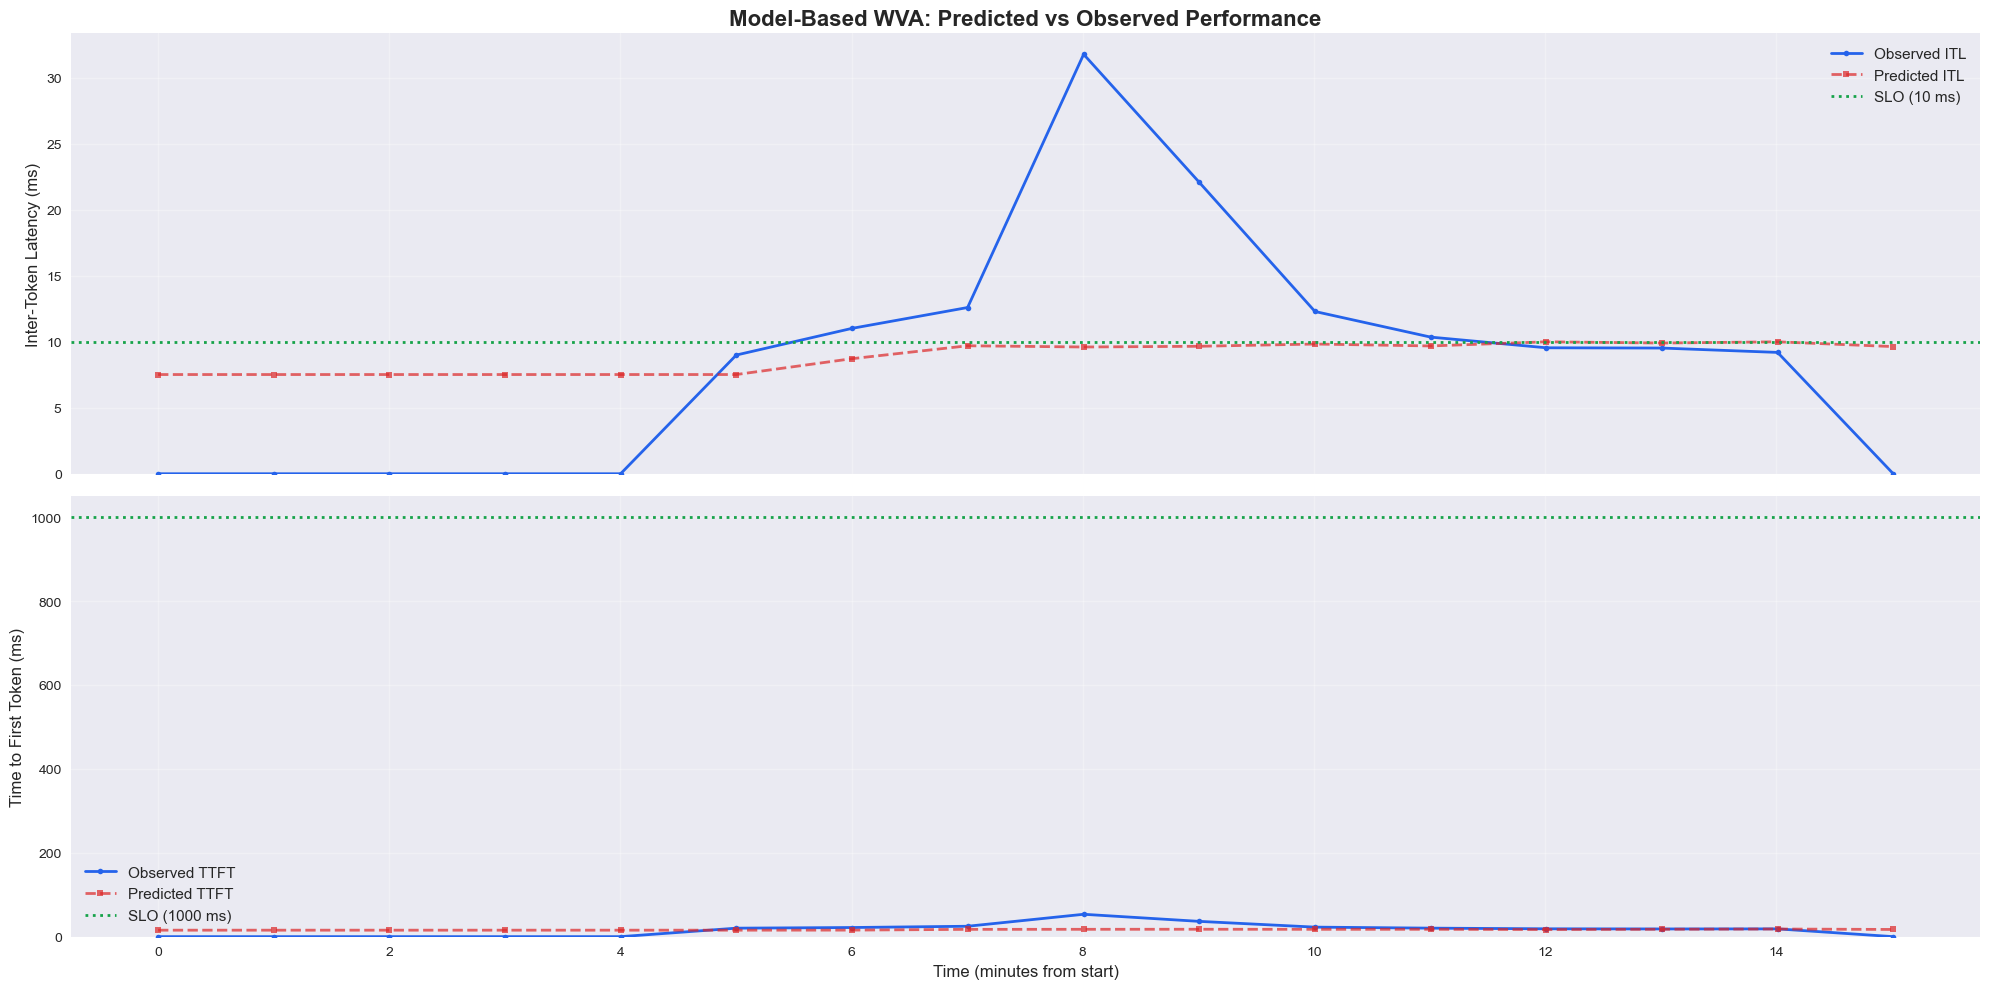

In [8]:
if len(df_aligned) > 0:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
    
    # ITL Comparison
    ax1.plot(df_aligned['time_minutes'], df_aligned['observed_itl'], 
             'o-', label='Observed ITL', color='#2563eb', linewidth=2, markersize=4)
    ax1.plot(df_aligned['time_minutes'], df_aligned['predicted_itl'], 
             's--', label='Predicted ITL', color='#dc2626', linewidth=2, markersize=4, alpha=0.7)
    ax1.axhline(y=SLO_ITL, color='#16a34a', linestyle=':', linewidth=2, label=f'SLO ({SLO_ITL} ms)')
    
    ax1.set_ylabel('Inter-Token Latency (ms)', fontsize=12)
    ax1.set_title('Model-Based WVA: Predicted vs Observed Performance', fontweight='bold', fontsize=16)
    ax1.legend(loc='best', fontsize=11, framealpha=0.9)
    ax1.grid(True, alpha=0.3, which='both')
    ax1.set_ylim(bottom=0)
    
    # TTFT Comparison
    ax2.plot(df_aligned['time_minutes'], df_aligned['observed_ttft'], 
             'o-', label='Observed TTFT', color='#2563eb', linewidth=2, markersize=4)
    ax2.plot(df_aligned['time_minutes'], df_aligned['predicted_ttft'], 
             's--', label='Predicted TTFT', color='#dc2626', linewidth=2, markersize=4, alpha=0.7)
    ax2.axhline(y=SLO_TTFT, color='#16a34a', linestyle=':', linewidth=2, label=f'SLO ({SLO_TTFT} ms)')
    
    ax2.set_xlabel('Time (minutes from start)', fontsize=12)
    ax2.set_ylabel('Time to First Token (ms)', fontsize=12)
    ax2.legend(loc='best', fontsize=11, framealpha=0.9)
    ax2.grid(True, alpha=0.3, which='both')
    ax2.set_ylim(bottom=0)
    
    plt.tight_layout()
    
    # Save plot
    plots_dir = EXPERIMENT_DIR / 'plots'
    plots_dir.mkdir(exist_ok=True)
    plt.savefig(plots_dir / 'predicted_vs_observed.png', dpi=150, bbox_inches='tight')
    
    plt.show()
else:
    print("No aligned data available for plotting")

## 8. Visualization: Scaling Behavior

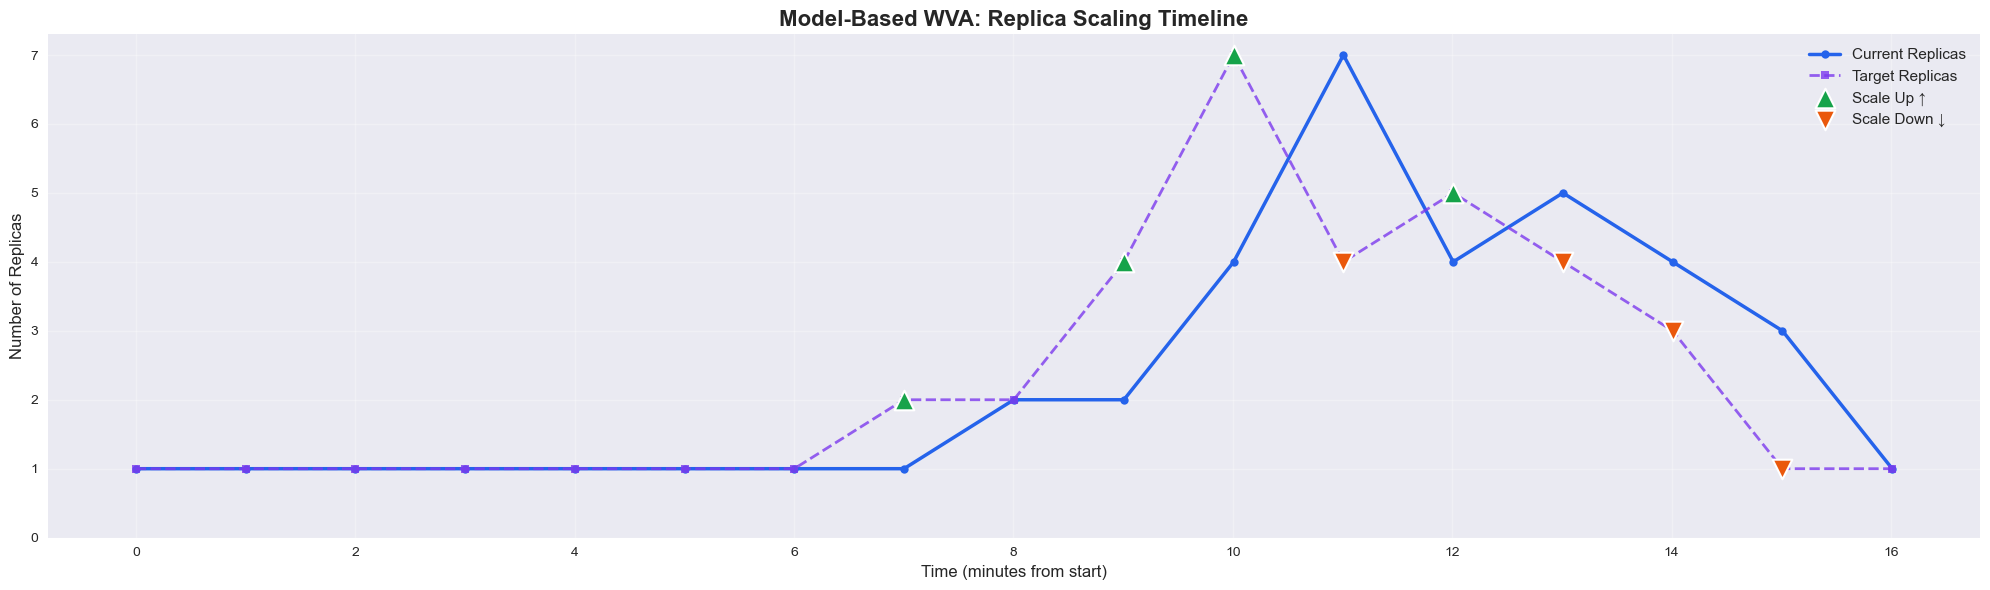

In [ ]:
if len(df_scaling) > 0:
    fig, ax = plt.subplots(figsize=(20, 6))
    
    # Calculate relative times
    start_time = df_scaling['timestamp'].min()
    df_scaling['time_minutes'] = (df_scaling['timestamp'] - start_time).dt.total_seconds() / 60
    
    # Plot current replicas (actual)
    ax.plot(df_scaling['time_minutes'], df_scaling['current_replicas'], 
            '-o', label='Current Replicas', color='#2563eb', markersize=5, linewidth=2.5)
    
    # Plot desired replicas (target from WVA decisions)
    if SHOW_DESIRED_REPLICAS and 'target_replicas' in df_scaling.columns:
        ax.step(df_scaling['time_minutes'], df_scaling['target_replicas'], 
                where='post', label='Desired Replicas (WVA Decision)', 
                linewidth=2.5, linestyle='--', color='#dc2626', alpha=0.8)
    
    # Annotate scaling actions (optional - commented out to reduce clutter)
    # scale_up = df_scaling[df_scaling['action'] == 'scale-up']
    # scale_down = df_scaling[df_scaling['action'] == 'scale-down']
    # 
    # if len(scale_up) > 0:
    #     ax.scatter(scale_up['time_minutes'], scale_up['target_replicas'], 
    #                color='#16a34a', s=200, marker='^', label='Scale Up ↑', zorder=5, edgecolors='white', linewidth=1.5)
    # 
    # if len(scale_down) > 0:
    #     ax.scatter(scale_down['time_minutes'], scale_down['target_replicas'], 
    #                color='#ea580c', s=200, marker='v', label='Scale Down ↓', zorder=5, edgecolors='white', linewidth=1.5)
    
    ax.set_xlabel('Time (minutes from start)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Replicas', fontsize=12, fontweight='bold')
    ax.set_title('Model-Based WVA: Replica Scaling Timeline', fontsize=16, fontweight='bold')
    ax.legend(loc='best', fontsize=11, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(bottom=0)
    
    # Use integer y-axis
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    plt.tight_layout()
    plt.savefig(EXPERIMENT_DIR / 'plots' / 'scaling_behavior.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No scaling data to plot")

## 8.5 Visualization: Scaling Decisions with ITL Context

Show scaling decisions alongside observed ITL to understand performance impact.

In [ ]:
if len(df_scaling) > 0 and len(df_aligned) > 0:
    fig, ax = plt.subplots(figsize=(20, 6))
    
    # Create twin axis
    ax2 = ax.twinx()
    
    # Calculate relative times for scaling data if not already present
    if 'time_minutes' not in df_scaling.columns:
        start_time = df_scaling['timestamp'].min()
        df_scaling['time_minutes'] = (df_scaling['timestamp'] - start_time).dt.total_seconds() / 60
    
    # Plot actual replicas on left axis (blue)
    ax.plot(df_scaling['time_minutes'], df_scaling['current_replicas'], 
            '-o', color='#2563eb', label='Current Replicas', markersize=5, linewidth=2.5)
    
    # Plot desired replicas if enabled and available
    if SHOW_DESIRED_REPLICAS and 'target_replicas' in df_scaling.columns:
        ax.step(df_scaling['time_minutes'], df_scaling['target_replicas'], 
                where='post', label='Desired Replicas (WVA Decision)', 
                linewidth=2.5, linestyle='--', color='#dc2626', alpha=0.8)
    
    # Plot observed ITL on right axis (green)
    ax2.plot(df_aligned['time_minutes'], df_aligned['observed_itl'], 
             color='#16a34a', linestyle='--', marker='s', label='Observed ITL', 
             markersize=5, linewidth=2.5, alpha=0.8)
    
    # Add SLO threshold on right axis
    ax2.axhline(y=SLO_ITL, color='#ea580c', linestyle=':', 
                label=f'SLO ITL ({SLO_ITL} ms)', linewidth=2, alpha=0.8)
    
    # Color-code axes labels to match plots
    ax.set_ylabel('Replicas', fontsize=12, fontweight='bold', color='#2563eb')
    ax.tick_params(axis='y', labelcolor='#2563eb')
    
    ax2.set_ylabel('Inter-Token Latency (ms)', fontsize=12, fontweight='bold', color='#16a34a')
    ax2.tick_params(axis='y', labelcolor='#16a34a')
    
    ax.set_xlabel('Time (minutes from start)', fontsize=12, fontweight='bold')
    ax.set_title('Scaling Decisions with ITL Performance Context', fontsize=16, fontweight='bold')
    
    # Combine legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=11, framealpha=0.9)
    
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax2.set_ylim(bottom=0)
    
    plt.tight_layout()
    plt.savefig(EXPERIMENT_DIR / 'plots' / 'scaling_itl_context.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Scaling decisions with ITL context plot complete")
elif len(df_scaling) == 0:
    print("⚠️  No scaling data available for context plot")
else:
    print("⚠️  No aligned observation data available for ITL context plot")

## 8.7 Visualization: Scaling Decisions with TTFT Context

Show scaling decisions alongside observed TTFT to understand first-token performance impact.

In [ ]:
if len(df_scaling) > 0 and len(df_aligned) > 0:
    fig, ax = plt.subplots(figsize=(20, 6))
    
    # Create twin axis
    ax2 = ax.twinx()
    
    # Calculate relative times for scaling data if not already present
    if 'time_minutes' not in df_scaling.columns:
        start_time = df_scaling['timestamp'].min()
        df_scaling['time_minutes'] = (df_scaling['timestamp'] - start_time).dt.total_seconds() / 60
    
    # Plot actual replicas on left axis (blue)
    ax.plot(df_scaling['time_minutes'], df_scaling['current_replicas'], 
            '-o', color='#2563eb', label='Current Replicas', markersize=5, linewidth=2.5)
    
    # Plot desired replicas if enabled and available
    if SHOW_DESIRED_REPLICAS and 'target_replicas' in df_scaling.columns:
        ax.step(df_scaling['time_minutes'], df_scaling['target_replicas'], 
                where='post', label='Desired Replicas (WVA Decision)', 
                linewidth=2.5, linestyle='--', color='#dc2626', alpha=0.8)
    
    # Plot observed TTFT on right axis (purple)
    ax2.plot(df_aligned['time_minutes'], df_aligned['observed_ttft'], 
             color='#8b5cf6', linestyle='--', marker='s', label='Observed TTFT', 
             markersize=5, linewidth=2.5, alpha=0.8)
    
    # Add SLO threshold on right axis
    ax2.axhline(y=SLO_TTFT, color='#ea580c', linestyle=':', 
                label=f'SLO TTFT ({SLO_TTFT} ms)', linewidth=2, alpha=0.8)
    
    # Color-code axes labels to match plots
    ax.set_ylabel('Replicas', fontsize=12, fontweight='bold', color='#2563eb')
    ax.tick_params(axis='y', labelcolor='#2563eb')
    
    ax2.set_ylabel('Time to First Token (ms)', fontsize=12, fontweight='bold', color='#8b5cf6')
    ax2.tick_params(axis='y', labelcolor='#8b5cf6')
    
    ax.set_xlabel('Time (minutes from start)', fontsize=12, fontweight='bold')
    ax.set_title('Scaling Decisions with TTFT Performance Context', fontsize=16, fontweight='bold')
    
    # Combine legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=11, framealpha=0.9)
    
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax2.set_ylim(bottom=0)
    
    plt.tight_layout()
    plt.savefig(EXPERIMENT_DIR / 'plots' / 'scaling_ttft_context.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Scaling decisions with TTFT context plot complete")
elif len(df_scaling) == 0:
    print("⚠️  No scaling data available for context plot")
else:
    print("⚠️  No aligned observation data available for TTFT context plot")

## 9. Visualization: Prediction Error Distribution

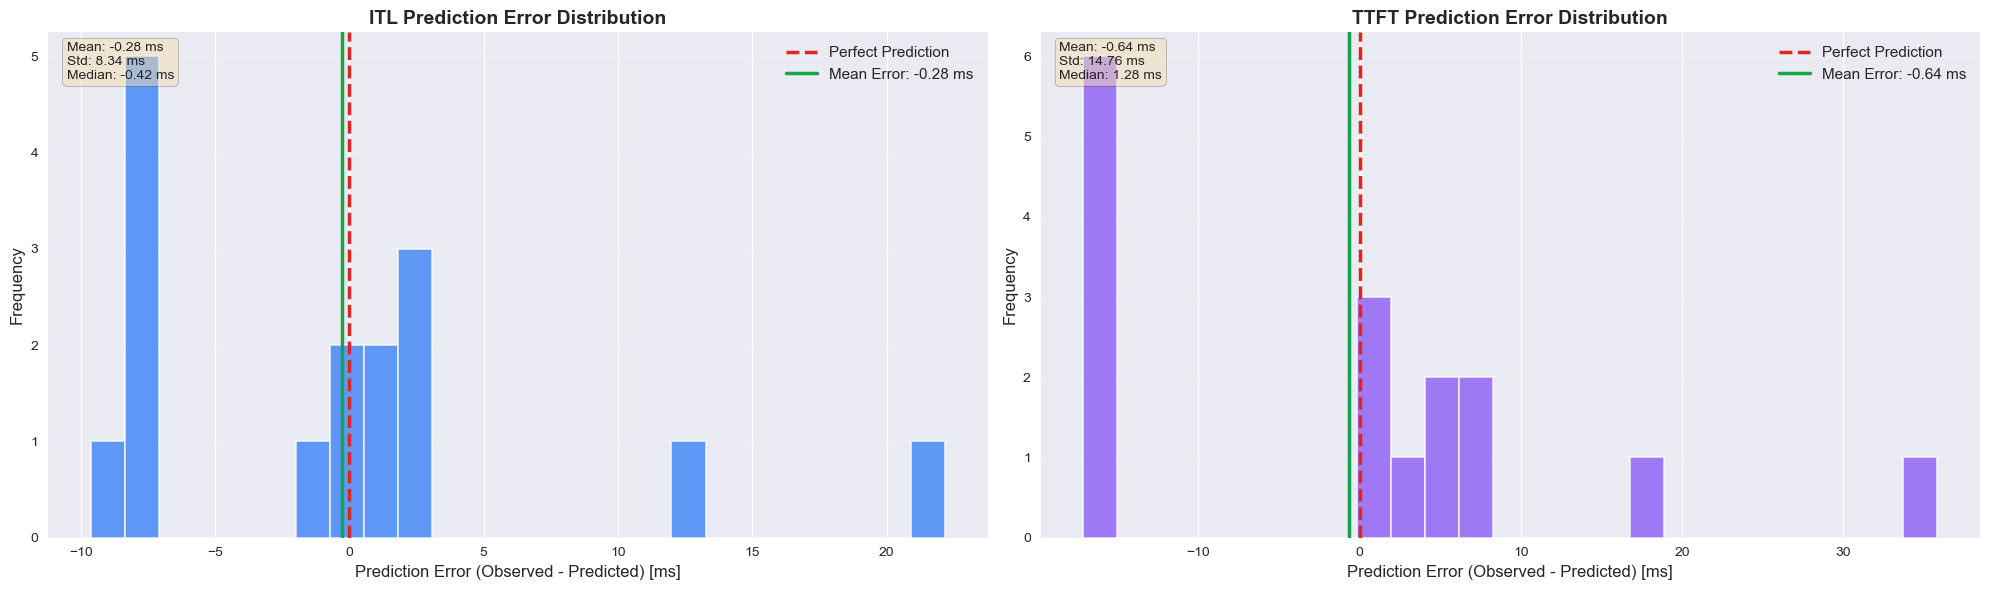

In [10]:
if len(df_aligned) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    
    # ITL Error Distribution
    ax = axes[0]
    errors = df_aligned['pred_error_itl'].dropna()
    if len(errors) > 0:
        ax.hist(errors, bins=25, color='#3b82f6', edgecolor='white', alpha=0.8, linewidth=1.2)
        ax.axvline(x=0, color='#dc2626', linestyle='--', linewidth=2.5, label='Perfect Prediction', zorder=5)
        ax.axvline(x=errors.mean(), color='#16a34a', linestyle='-', linewidth=2.5, 
                   label=f'Mean Error: {errors.mean():.2f} ms', zorder=5)
        
        ax.set_xlabel('Prediction Error (Observed - Predicted) [ms]', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.set_title('ITL Prediction Error Distribution', fontsize=14, fontweight='bold')
        ax.legend(fontsize=11, framealpha=0.9)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add statistics text box
        stats_text = f'Mean: {errors.mean():.2f} ms\nStd: {errors.std():.2f} ms\nMedian: {errors.median():.2f} ms'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # TTFT Error Distribution
    ax = axes[1]
    errors = df_aligned['pred_error_ttft'].dropna()
    if len(errors) > 0:
        ax.hist(errors, bins=25, color='#8b5cf6', edgecolor='white', alpha=0.8, linewidth=1.2)
        ax.axvline(x=0, color='#dc2626', linestyle='--', linewidth=2.5, label='Perfect Prediction', zorder=5)
        ax.axvline(x=errors.mean(), color='#16a34a', linestyle='-', linewidth=2.5, 
                   label=f'Mean Error: {errors.mean():.2f} ms', zorder=5)
        
        ax.set_xlabel('Prediction Error (Observed - Predicted) [ms]', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.set_title('TTFT Prediction Error Distribution', fontsize=14, fontweight='bold')
        ax.legend(fontsize=11, framealpha=0.9)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add statistics text box
        stats_text = f'Mean: {errors.mean():.2f} ms\nStd: {errors.std():.2f} ms\nMedian: {errors.median():.2f} ms'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(EXPERIMENT_DIR / 'plots' / 'prediction_error_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No aligned data available for error distribution")

## 10. Export Processed Data

In [11]:
# Save processed data
if len(df_aligned) > 0:
    output_file = EXPERIMENT_DIR / 'processed_data.csv'
    df_aligned.to_csv(output_file, index=False)
    print(f"✓ Saved processed data to: {output_file}")

# Create summary report
if len(df_aligned) > 0:
    summary_file = EXPERIMENT_DIR / 'ANALYSIS_SUMMARY.md'
    
    with open(summary_file, 'w') as f:
        f.write(f"# WVA Model-Based Experiment Analysis\n\n")
        f.write(f"**Experiment:** {EXPERIMENT_DIR.name}\n\n")
        f.write(f"**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write(f"---\n\n")
        
        f.write(f"## Summary Statistics\n\n")
        f.write(f"- **Total Predictions:** {len(df_predictions)}\n")
        f.write(f"- **Total Observations:** {len(df_observations)}\n")
        f.write(f"- **Aligned Pairs:** {len(df_aligned)}\n")
        f.write(f"- **Scaling Decisions:** {len(df_scaling)}\n\n")
        
        f.write(f"## SLO Configuration\n\n")
        f.write(f"- **ITL SLO:** {SLO_ITL} ms\n")
        f.write(f"- **TTFT SLO:** {SLO_TTFT} ms\n\n")
        
        violation_count = df_aligned['any_slo_violated'].sum()
        violation_pct = (violation_count / len(df_aligned)) * 100
        f.write(f"- **SLO Violations:** {violation_count}/{len(df_aligned)} ({violation_pct:.1f}%)\n\n")
        
        f.write(f"## Prediction Accuracy\n\n")
        f.write(f"### ITL Predictions\n\n")
        f.write(f"- Mean Error: {df_aligned['pred_error_itl'].mean():.2f} ms\n")
        f.write(f"- Abs Mean Error: {df_aligned['pred_error_itl'].abs().mean():.2f} ms\n")
        f.write(f"- Std Dev: {df_aligned['pred_error_itl'].std():.2f} ms\n\n")
        
        f.write(f"### TTFT Predictions\n\n")
        f.write(f"- Mean Error: {df_aligned['pred_error_ttft'].mean():.2f} ms\n")
        f.write(f"- Abs Mean Error: {df_aligned['pred_error_ttft'].abs().mean():.2f} ms\n")
        f.write(f"- Std Dev: {df_aligned['pred_error_ttft'].std():.2f} ms\n\n")
        
        if len(df_scaling) > 0:
            f.write(f"## Scaling Behavior\n\n")
            action_counts = df_scaling['action'].value_counts()
            for action, count in action_counts.items():
                pct = (count / len(df_scaling)) * 100
                f.write(f"- {action}: {count} ({pct:.1f}%)\n")
            f.write(f"\n- Replica Range: {df_scaling['current_replicas'].min()} - {df_scaling['current_replicas'].max()}\n\n")
        
        f.write(f"## Files Generated\n\n")
        f.write(f"- `processed_data.csv` - Aligned prediction-observation pairs\n")
        f.write(f"- `plots/prediction_vs_observation.png` - ITL/TTFT over time\n")
        f.write(f"- `plots/scaling_behavior.png` - Replica scaling timeline\n")
        f.write(f"- `plots/prediction_error_distribution.png` - Error histograms\n")
    
    print(f"✓ Saved summary report to: {summary_file}")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print(f"Results saved to: {EXPERIMENT_DIR}")

✓ Saved processed data to: /Users/tom/Desktop/llm-d-communitydev/tom_wva/config/samples/wva-experiments/experiment-data/model-based-moderate-parallel-20251203-144456/processed_data.csv
✓ Saved summary report to: /Users/tom/Desktop/llm-d-communitydev/tom_wva/config/samples/wva-experiments/experiment-data/model-based-moderate-parallel-20251203-144456/ANALYSIS_SUMMARY.md

ANALYSIS COMPLETE
Results saved to: /Users/tom/Desktop/llm-d-communitydev/tom_wva/config/samples/wva-experiments/experiment-data/model-based-moderate-parallel-20251203-144456


## 10. Visualization: KV Cache Utilization

Visualizing KV cache usage across pods (if capacity metrics available).

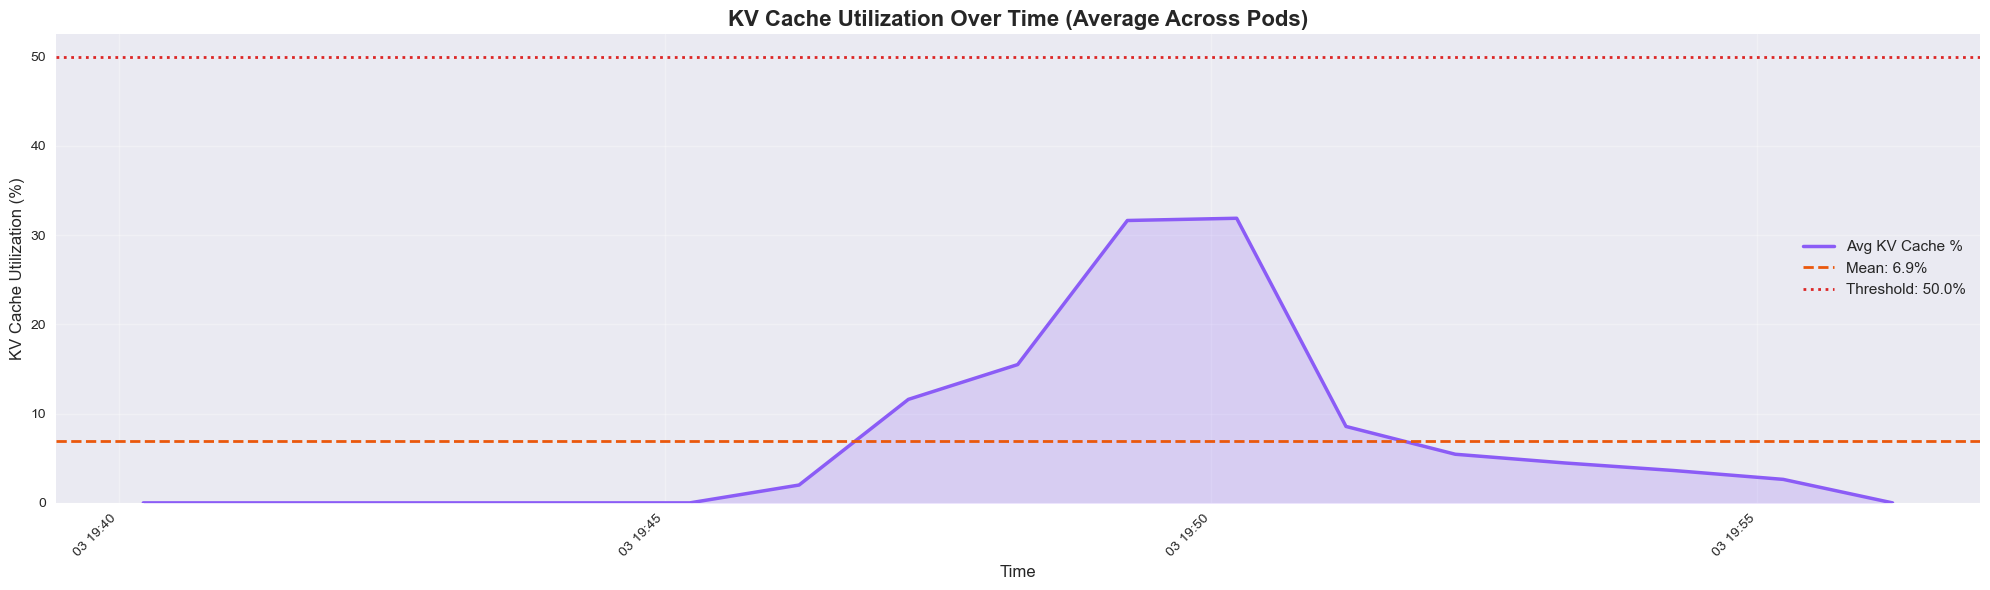

KV Cache Statistics:
  Mean: 6.91%
  Max: 31.90%
  Min: 0.00%
  Std: 10.40%


In [12]:
if len(df_kv_cache) > 0:
    # Aggregate KV cache usage across all pods
    df_kv_agg = df_kv_cache.groupby('timestamp').agg({
        'kv_cache_usage': 'mean',
        'kv_cache_pct': 'mean'
    }).reset_index()
    
    fig, ax = plt.subplots(figsize=(20, 6))
    
    # Plot KV cache percentage
    ax.plot(df_kv_agg['timestamp'], df_kv_agg['kv_cache_pct'], 
            '-', color='#8b5cf6', linewidth=2.5, label='Avg KV Cache %')
    ax.fill_between(df_kv_agg['timestamp'], 0, df_kv_agg['kv_cache_pct'], 
                     color='#8b5cf6', alpha=0.2)
    
    # Add mean line
    mean_pct = df_kv_agg['kv_cache_pct'].mean()
    ax.axhline(y=mean_pct, color='#ea580c', linestyle='--', linewidth=2,
               label=f'Mean: {mean_pct:.1f}%', zorder=5)
    
    # Add threshold line if exists
    if 'KV_CACHE_THRESHOLD' in dir():
        ax.axhline(y=KV_CACHE_THRESHOLD*100, color='#dc2626', linestyle=':', linewidth=2,
                   label=f'Threshold: {KV_CACHE_THRESHOLD*100}%', zorder=5)
    
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('KV Cache Utilization (%)', fontsize=12)
    ax.set_title('KV Cache Utilization Over Time (Average Across Pods)', 
                 fontsize=16, fontweight='bold')
    ax.legend(loc='best', fontsize=11, framealpha=0.9)
    ax.grid(True, alpha=0.3, which='both')
    ax.set_ylim(bottom=0)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(EXPERIMENT_DIR / 'plots' / 'kv_cache_utilization.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"KV Cache Statistics:")
    print(f"  Mean: {df_kv_agg['kv_cache_pct'].mean():.2f}%")
    print(f"  Max: {df_kv_agg['kv_cache_pct'].max():.2f}%")
    print(f"  Min: {df_kv_agg['kv_cache_pct'].min():.2f}%")
    print(f"  Std: {df_kv_agg['kv_cache_pct'].std():.2f}%")
else:
    print("⚠️ No KV cache metrics available in logs")

## 11. Visualization: Queue Length

Visualizing request queue length across pods (if capacity metrics available).

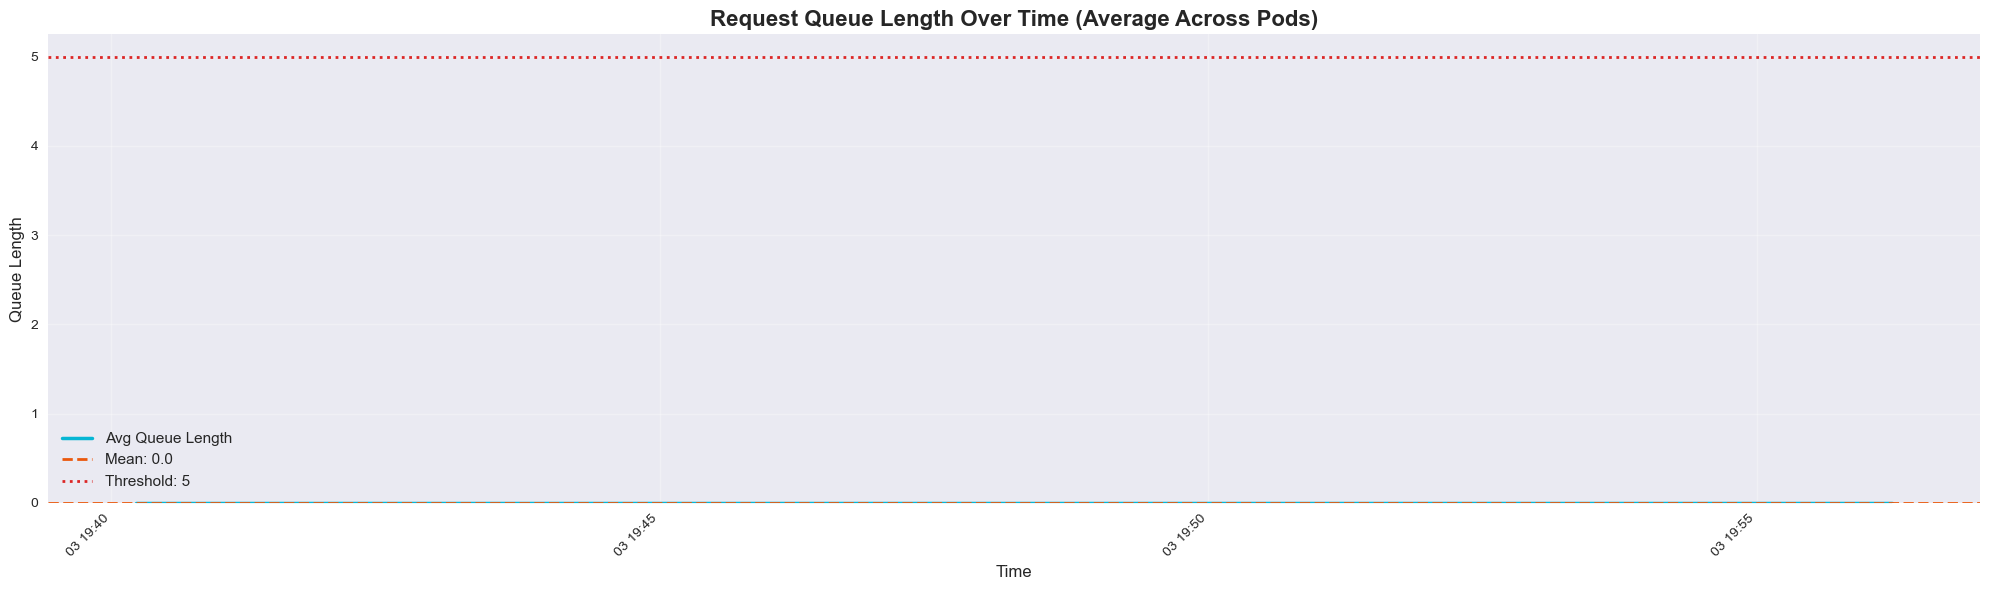

Queue Length Statistics:
  Mean: 0.00
  Max: 0.00
  Min: 0.00
  Std: 0.00


In [13]:
if len(df_queue) > 0:
    # Aggregate queue length across all pods
    df_queue_agg = df_queue.groupby('timestamp').agg({
        'queue_length': 'mean'
    }).reset_index()
    
    fig, ax = plt.subplots(figsize=(20, 6))
    
    # Plot queue length
    ax.plot(df_queue_agg['timestamp'], df_queue_agg['queue_length'], 
            '-', color='#06b6d4', linewidth=2.5, label='Avg Queue Length')
    ax.fill_between(df_queue_agg['timestamp'], 0, df_queue_agg['queue_length'], 
                     color='#06b6d4', alpha=0.2)
    
    # Add mean line
    mean_queue = df_queue_agg['queue_length'].mean()
    ax.axhline(y=mean_queue, color='#ea580c', linestyle='--', linewidth=2,
               label=f'Mean: {mean_queue:.1f}', zorder=5)
    
    # Add threshold line if exists
    if 'QUEUE_LENGTH_THRESHOLD' in dir():
        ax.axhline(y=QUEUE_LENGTH_THRESHOLD, color='#dc2626', linestyle=':', linewidth=2,
                   label=f'Threshold: {QUEUE_LENGTH_THRESHOLD}', zorder=5)
    
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Queue Length', fontsize=12)
    ax.set_title('Request Queue Length Over Time (Average Across Pods)', 
                 fontsize=16, fontweight='bold')
    ax.legend(loc='best', fontsize=11, framealpha=0.9)
    ax.grid(True, alpha=0.3, which='both')
    ax.set_ylim(bottom=0)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(EXPERIMENT_DIR / 'plots' / 'queue_length.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Queue Length Statistics:")
    print(f"  Mean: {df_queue_agg['queue_length'].mean():.2f}")
    print(f"  Max: {df_queue_agg['queue_length'].max():.2f}")
    print(f"  Min: {df_queue_agg['queue_length'].min():.2f}")
    print(f"  Std: {df_queue_agg['queue_length'].std():.2f}")
else:
    print("⚠️ No queue metrics available in logs")

## 12. Export Processed Data

In [14]:
# Save processed data
OUTPUT_DIR = EXPERIMENT_DIR / "processed"
OUTPUT_DIR.mkdir(exist_ok=True)

# Save dataframes
if len(df_predictions) > 0:
    df_predictions.to_csv(OUTPUT_DIR / "predictions.csv", index=False)
    print(f"✓ Saved predictions to {OUTPUT_DIR / 'predictions.csv'}")

if len(df_observations) > 0:
    df_observations.to_csv(OUTPUT_DIR / "observations.csv", index=False)
    print(f"✓ Saved observations to {OUTPUT_DIR / 'observations.csv'}")

if len(df_scaling) > 0:
    df_scaling.to_csv(OUTPUT_DIR / "scaling_decisions.csv", index=False)
    print(f"✓ Saved scaling decisions to {OUTPUT_DIR / 'scaling_decisions.csv'}")

if len(df_slo) > 0:
    df_slo.to_csv(OUTPUT_DIR / "slo_values.csv", index=False)
    print(f"✓ Saved SLO values to {OUTPUT_DIR / 'slo_values.csv'}")

if len(df_kv_cache) > 0:
    df_kv_cache.to_csv(OUTPUT_DIR / "kv_cache_metrics.csv", index=False)
    print(f"✓ Saved KV cache metrics to {OUTPUT_DIR / 'kv_cache_metrics.csv'}")

if len(df_queue) > 0:
    df_queue.to_csv(OUTPUT_DIR / "queue_metrics.csv", index=False)
    print(f"✓ Saved queue metrics to {OUTPUT_DIR / 'queue_metrics.csv'}")

# Create summary report
REPORT_FILE = OUTPUT_DIR / "analysis_report.txt"
with open(REPORT_FILE, 'w') as f:
    f.write(f"Model-Based WVA Experiment Analysis Report\n")
    f.write(f"{'=' * 80}\n\n")
    f.write(f"Experiment: {EXPERIMENT_DIR.name}\n")
    f.write(f"Data Directory: {EXPERIMENT_DIR}\n")
    f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write(f"## Summary Statistics\n\n")
    
    if len(df_predictions) > 0:
        f.write(f"### Predictions\n")
        f.write(f"Total predictions: {len(df_predictions)}\n\n")
    
    if len(df_observations) > 0:
        f.write(f"### Observations\n")
        f.write(f"Total observations: {len(df_observations)}\n")
        if 'observed_ttft' in df_observations.columns:
            f.write(f"Avg TTFT: {df_observations['observed_ttft'].mean():.2f} ms\n")
        if 'observed_itl' in df_observations.columns:
            f.write(f"Avg ITL: {df_observations['observed_itl'].mean():.2f} ms\n\n")
    
    if len(df_scaling) > 0:
        f.write(f"### Scaling Decisions\n")
        f.write(f"Total scaling decisions: {len(df_scaling)}\n")
        action_counts = df_scaling['action'].value_counts()
        for action, count in action_counts.items():
            f.write(f"  {action}: {count}\n")
        f.write(f"\n")
    
    if len(df_kv_cache) > 0:
        df_kv_agg = df_kv_cache.groupby('timestamp').agg({'kv_cache_pct': 'mean'}).reset_index()
        f.write(f"### KV Cache Utilization\n")
        f.write(f"Mean: {df_kv_agg['kv_cache_pct'].mean():.2f}%\n")
        f.write(f"Max: {df_kv_agg['kv_cache_pct'].max():.2f}%\n")
        f.write(f"Min: {df_kv_agg['kv_cache_pct'].min():.2f}%\n\n")
    
    if len(df_queue) > 0:
        df_queue_agg = df_queue.groupby('timestamp').agg({'queue_length': 'mean'}).reset_index()
        f.write(f"### Queue Length\n")
        f.write(f"Mean: {df_queue_agg['queue_length'].mean():.2f}\n")
        f.write(f"Max: {df_queue_agg['queue_length'].max():.2f}\n")
        f.write(f"Min: {df_queue_agg['queue_length'].min():.2f}\n\n")

print(f"\n✓ Analysis report saved to {REPORT_FILE}")

✓ Saved predictions to /Users/tom/Desktop/llm-d-communitydev/tom_wva/config/samples/wva-experiments/experiment-data/model-based-moderate-parallel-20251203-144456/processed/predictions.csv
✓ Saved observations to /Users/tom/Desktop/llm-d-communitydev/tom_wva/config/samples/wva-experiments/experiment-data/model-based-moderate-parallel-20251203-144456/processed/observations.csv
✓ Saved scaling decisions to /Users/tom/Desktop/llm-d-communitydev/tom_wva/config/samples/wva-experiments/experiment-data/model-based-moderate-parallel-20251203-144456/processed/scaling_decisions.csv
✓ Saved SLO values to /Users/tom/Desktop/llm-d-communitydev/tom_wva/config/samples/wva-experiments/experiment-data/model-based-moderate-parallel-20251203-144456/processed/slo_values.csv
✓ Saved KV cache metrics to /Users/tom/Desktop/llm-d-communitydev/tom_wva/config/samples/wva-experiments/experiment-data/model-based-moderate-parallel-20251203-144456/processed/kv_cache_metrics.csv
✓ Saved queue metrics to /Users/tom/De